# Content:
## 1. EDA

**The dataset contains data from two different hotels. One Resort hotel and one City hotel.**

From the publication (https://www.sciencedirect.com/science/article/pii/S2352340918315191) We are aware that both hotels are situated in Portugal, specifically in the southern region of Europe. "H1" is located in the resort region of Algarve, while "H2" is situated in the city of Lisbon. These two locations are approximately 280 kilometers apart by car, and both of them are adjacent to the North Atlantic.

The dataset encompasses bookings scheduled to arrive between July 1, 2015, and August 31, 2017. It is important to note that, for most inquiries, only bookings that were not canceled will be considered to obtain the actual number of guests. As you will observe, this distinction yields a significant difference.

The following topics will be covered, and the corresponding questions will be addressed using the available data:

1. Guest Origins:
   - Where do the guests originate from?

2. Room Rates:
   - What is the average price paid per night by guests?

3. Seasonal Price Variation:
   - How does the price per night fluctuate throughout the year?

4. Busiest Month:
   - Which month experiences the highest influx of guests?

5. Duration of Stay:
   - How long do people typically stay at the hotels?

6. Bookings by Market Segment:
   - How are the bookings distributed among different market segments?

7. Canceled Bookings:
   - How many bookings were canceled?

8. Month with the Highest Number of Cancellations:
   - During which month did the highest number of cancellations occur?

## 2. Forecasting Cancellations

Having a predictive model to anticipate whether a guest will follow through with their booking would greatly benefit the hotels. This capability enables them to effectively plan personnel allocation and estimate food requirements. Additionally, it is possible that certain hotels leverage such models to overbook their rooms, potentially aiming to maximize their revenue. The true intentions behind these practices remain speculative.

3. Assessing the Significance of Features

To determine the factors that hold the most significance in predicting cancellations, it is essential to evaluate the importance of various features.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import folium

# for ML:
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import eli5 # Feature importance evaluation



# set some display options:
sns.set(style="whitegrid")
pd.set_option("display.max_columns", 36)

# load data:
file_path = "../input/hotel-booking-demand/hotel_bookings.csv"
data = pd.read_csv(file_path)

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
print("Data Shape:", data.shape)

Data Shape: (119390, 32)


### Data Info

|variable                       |class     |description |
|:------------------------------|:---------|:-----------|
|hotel                          |character | Hotel (H1 = Resort Hotel or H2 = City Hotel) |
|is_canceled                    |double    | Value indicating if the booking was canceled (1) or not (0) |
|lead_time                      |double    | Number of days that elapsed between the entering date of the booking into the PMS and the arrival date |
|arrival_date_year              |double    | Year of arrival date|
|arrival_date_month             |character | Month of arrival date|
|arrival_date_week_number       |double    | Week number of year for arrival date|
|arrival_date_day_of_month      |double    | Day of arrival date|
|stays_in_weekend_nights        |double    | Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel |
|stays_in_week_nights           |double    |  Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel|
|adults                         |double    | Number of adults|
|children                       |double    | Number of children|
|babies                         |double    |Number of babies |
|meal                           |character | Type of meal booked. Categories are presented in standard hospitality meal packages: <br> Undefined/SC – no meal package;<br>BB – Bed & Breakfast; <br> HB – Half board (breakfast and one other meal – usually dinner); <br> FB – Full board (breakfast, lunch and dinner) |
|country                        |character | Country of origin. Categories are represented in the ISO 3155–3:2013 format |
|market_segment                 |character | Market segment designation. In categories, the term "TA" means "Travel Agents" and "TO" means "Tour Operators" |
|distribution_channel           |character | Booking distribution channel. The term "TA" means "Travel Agents" and "TO" means "Tour Operators" |
|is_repeated_guest              |double    | Value indicating if the booking name was from a repeated guest (1) or not (0) |
|previous_cancellations         |double    | Number of previous bookings that were cancelled by the customer prior to the current booking |
|previous_bookings_not_canceled |double    | Number of previous bookings not cancelled by the customer prior to the current booking |
|reserved_room_type             |character | Code of room type reserved. Code is presented instead of designation for anonymity reasons |
|assigned_room_type             |character | Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. Code is presented instead of designation for anonymity reasons |
|booking_changes                |double    | Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation|
|deposit_type                   |character | Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories:<br>No Deposit – no deposit was made;<br>Non Refund – a deposit was made in the value of the total stay cost;<br>Refundable – a deposit was made with a value under the total cost of stay. |
|agent                          |character | ID of the travel agency that made the booking |
|company                        |character | ID of the company/entity that made the booking or responsible for paying the booking. ID is presented instead of designation for anonymity reasons |
|days_in_waiting_list           |double    | Number of days the booking was in the waiting list before it was confirmed to the customer |
|customer_type                  |character | Type of booking, assuming one of four categories:<br>Contract - when the booking has an allotment or other type of contract associated to it;<br>Group – when the booking is associated to a group;<br>Transient – when the booking is not part of a group or contract, and is not associated to other transient booking;<br>Transient-party – when the booking is transient, but is associated to at least other transient booking|
|adr                            |double    | Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights |
|required_car_parking_spaces    |double    | Number of car parking spaces required by the customer |
|total_of_special_requests      |double    | Number of special requests made by the customer (e.g. twin bed or high floor)|
|reservation_status             |character | Reservation last status, assuming one of three categories:<br>Canceled – booking was canceled by the customer;<br>Check-Out – customer has checked in but already departed;<br>No-Show – customer did not check-in and did inform the hotel of the reason why |
|reservation_status_date        |double    | Date at which the last status was set. This variable can be used in conjunction with the ReservationStatus to understand when was the booking canceled or when did the customer checked-out of the hotel|

In [4]:
# check for missing values
data.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [6]:
# Replace missing values:
# agent: If no agency is given, booking was most likely made without one.
# company: If none given, it was most likely private.
# rest schould be self-explanatory.
nan_replacements = {"children:": 0.0,"country": "Unknown", "agent": 0, "company": 0}
full_data_cln = data.fillna(nan_replacements)

# "meal" contains values "Undefined", which is equal to SC.
full_data_cln["meal"].replace("Undefined", "SC", inplace=True)

# Some rows contain entreis with 0 adults, 0 children and 0 babies. 
# I'm dropping these entries with no guests.
zero_guests = list(full_data_cln.loc[full_data_cln["adults"]
                   + full_data_cln["children"]
                   + full_data_cln["babies"]==0].index)
full_data_cln.drop(full_data_cln.index[zero_guests], inplace=True)

In [7]:
# How much data is left?
full_data_cln.shape

(119210, 32)

In [8]:
# After cleaning, separate Resort and City hotel
# To know the acutal visitor numbers, only bookings that were not canceled are included. 
rh = full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel") & (full_data_cln["is_canceled"] == 0)]
ch = full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel") & (full_data_cln["is_canceled"] == 0)]

Where do the guests originate from?

In [11]:
# get number of acutal guests by country
country_data = pd.DataFrame(full_data_cln.loc[full_data_cln["is_canceled"] == 0]["country"].value_counts())
#country_data.index.name = "country"
country_data.rename(columns={"country": "Number of Guests"}, inplace=True)
total_guests = country_data["Number of Guests"].sum()
country_data["Guests in %"] = round(country_data["Number of Guests"] / total_guests * 100, 2)
country_data["country"] = country_data.index
#country_data.loc[country_data["Guests in %"] < 2, "country"] = "Other"

# pie plot
fig = px.pie(country_data,
             values="Number of Guests",
             names="country",
             title="Home country of guests",
             template="seaborn")
fig.update_traces(textposition="inside", textinfo="value+percent+label")
fig.show()

In [12]:
# show on map
guest_map = px.choropleth(country_data,
                    locations=country_data.index,
                    color=country_data["Guests in %"], 
                    hover_name=country_data.index, 
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="Home country of guests")
guest_map.show()

Travelers from various corners of the globe choose to stay at these two hotels. While a significant number of guests originate from Portugal, there is also a substantial presence of visitors hailing from other European countries.

**What is the average price paid per night by guests?**

Each of the two hotels offers distinct room types and meal arrangements, contributing to significant variations in pricing. Moreover, seasonal factors play a crucial role in determining these prices, further adding to the diversity. As no specific currency information is provided, it can be assumed that all prices mentioned are denoted in EUR, considering Portugal's inclusion in the European Monetary Union.

In [13]:
# Counting adults and children as paying guests only, not babies.
rh["adr_pp"] = rh["adr"] / (rh["adults"] + rh["children"])
ch["adr_pp"] = ch["adr"] / (ch["adults"] + ch["children"])

In [14]:
print("""From all non-cnceled bookings, across all room types and meals, the average prices are:
Resort hotel: {:.2f} € per night and person.
City hotel: {:.2f} € per night and person."""
      .format(rh["adr_pp"].mean(), ch["adr_pp"].mean()))

From all non-cnceled bookings, across all room types and meals, the average prices are:
Resort hotel: 47.49 € per night and person.
City hotel: 59.27 € per night and person.


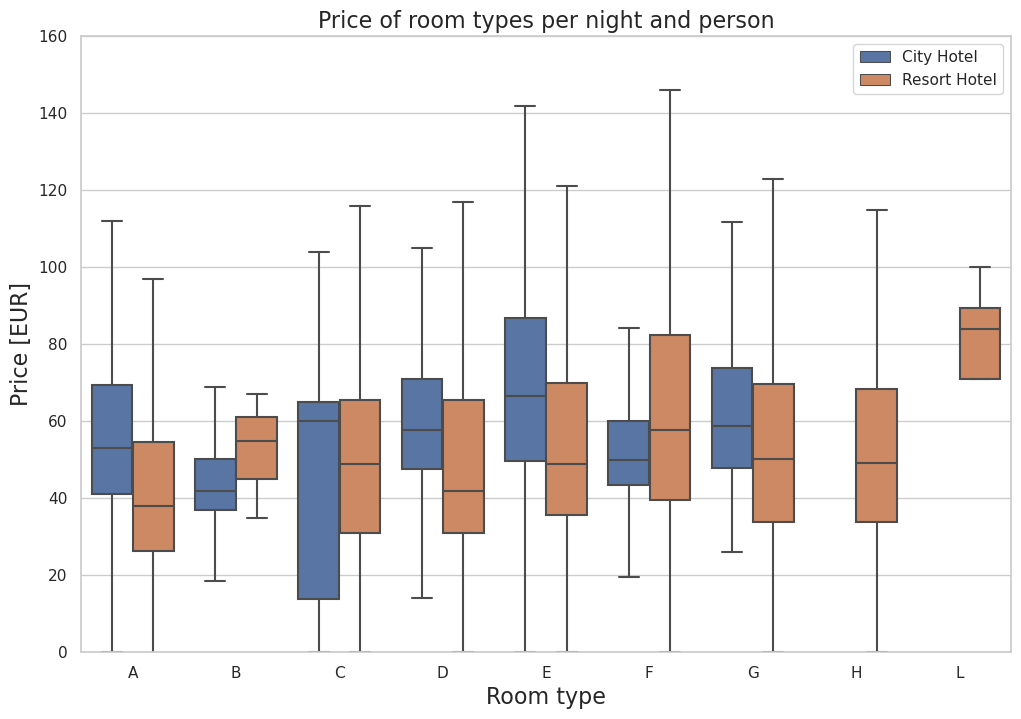

In [15]:
# normalize price per night (adr):
full_data_cln["adr_pp"] = full_data_cln["adr"] / (full_data_cln["adults"] + full_data_cln["children"])
full_data_guests = full_data_cln.loc[full_data_cln["is_canceled"] == 0] # only actual gusts
room_prices = full_data_guests[["hotel", "reserved_room_type", "adr_pp"]].sort_values("reserved_room_type")

# boxplot:
plt.figure(figsize=(12, 8))
sns.boxplot(x="reserved_room_type",
            y="adr_pp",
            hue="hotel",
            data=room_prices, 
            hue_order=["City Hotel", "Resort Hotel"],
            fliersize=0)
plt.title("Price of room types per night and person", fontsize=16)
plt.xlabel("Room type", fontsize=16)
plt.ylabel("Price [EUR]", fontsize=16)
plt.legend(loc="upper right")
plt.ylim(0, 160)
plt.show()

The presented figure illustrates the average price per room based on its type, accompanied by the corresponding standard deviation. It is important to note that, as a result of data anonymization, rooms sharing the same type letter may not necessarily be identical across the hotels.

**How does the price per night fluctuate throughout the year?**

For the sake of simplicity, I have opted to utilize the average price per night and per person, disregarding the specific room type and meal arrangements.

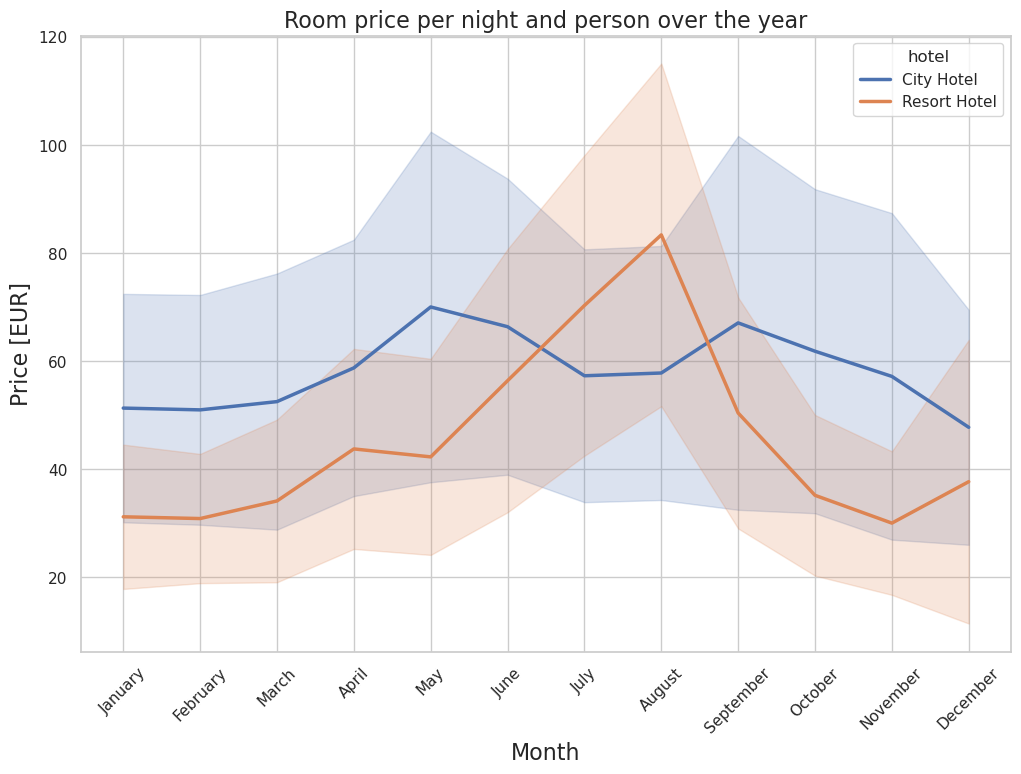

In [16]:
# grab data:
room_prices_mothly = full_data_guests[["hotel", "arrival_date_month", "adr_pp"]].sort_values("arrival_date_month")

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
room_prices_mothly["arrival_date_month"] = pd.Categorical(room_prices_mothly["arrival_date_month"], categories=ordered_months, ordered=True)

# barplot with standard deviation:
plt.figure(figsize=(12, 8))
sns.lineplot(x = "arrival_date_month", y="adr_pp", hue="hotel", data=room_prices_mothly, 
            hue_order = ["City Hotel", "Resort Hotel"], ci="sd", size="hotel", sizes=(2.5, 2.5))
plt.title("Room price per night and person over the year", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Price [EUR]", fontsize=16)
plt.show()

The data clearly indicates that prices in the Resort hotel experience a significant increase during the summer season, which comes as no surprise. In contrast, the price fluctuations in the city hotel are relatively less pronounced, with the highest rates observed during the spring and autumn periods.

# Which month experiences the highest influx of guests?

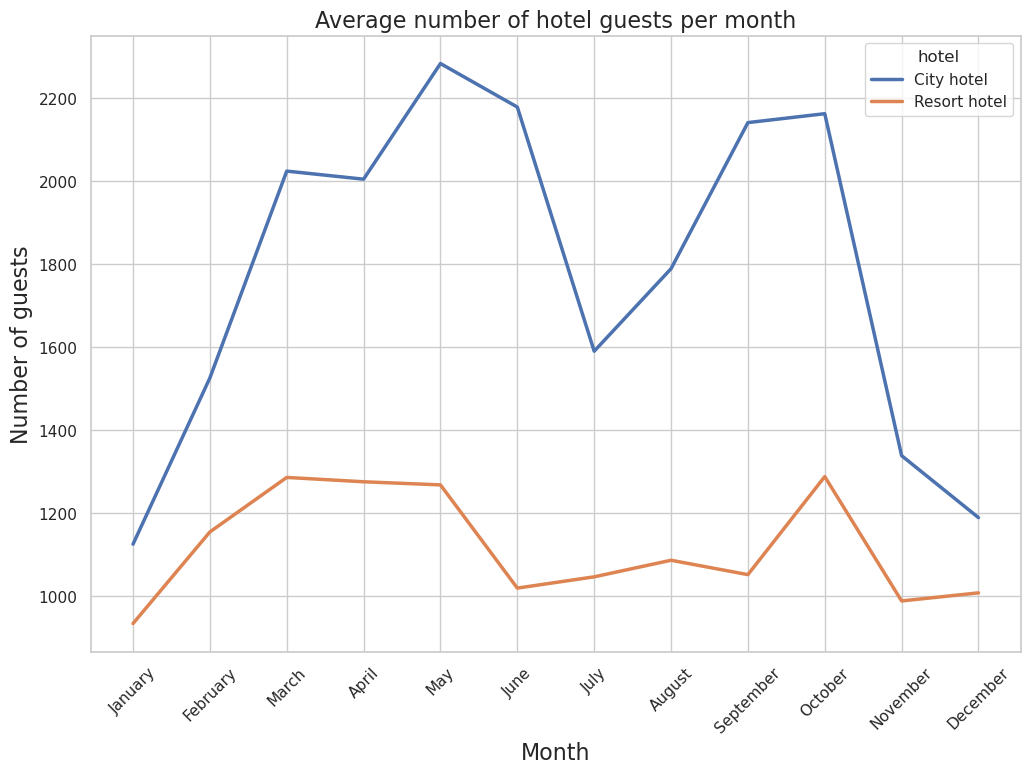

In [17]:
# Create a DateFrame with the relevant data:
resort_guests_monthly = rh.groupby("arrival_date_month")["hotel"].count()
city_guests_monthly = ch.groupby("arrival_date_month")["hotel"].count()

resort_guest_data = pd.DataFrame({"month": list(resort_guests_monthly.index),
                    "hotel": "Resort hotel", 
                    "guests": list(resort_guests_monthly.values)})

city_guest_data = pd.DataFrame({"month": list(city_guests_monthly.index),
                    "hotel": "City hotel", 
                    "guests": list(city_guests_monthly.values)})
full_guest_data = pd.concat([resort_guest_data,city_guest_data], ignore_index=True)

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
full_guest_data["month"] = pd.Categorical(full_guest_data["month"], categories=ordered_months, ordered=True)

# Dataset contains July and August date from 3 years, the other month from 2 years. Normalize data:
full_guest_data.loc[(full_guest_data["month"] == "July") | (full_guest_data["month"] == "August"),
                    "guests"] /= 3
full_guest_data.loc[~((full_guest_data["month"] == "July") | (full_guest_data["month"] == "August")),
                    "guests"] /= 2

#show figure:
plt.figure(figsize=(12, 8))
sns.lineplot(x = "month", y="guests", hue="hotel", data=full_guest_data, 
             hue_order = ["City hotel", "Resort hotel"], size="hotel", sizes=(2.5, 2.5))
plt.title("Average number of hotel guests per month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Number of guests", fontsize=16)
plt.show()

During the spring and autumn seasons, the City hotel experiences a higher influx of guests, coinciding with the period of peak prices. Conversely, in July and August, the number of visitors declines, despite the lower prices offered during that time.

In the case of the Resort hotel, guest numbers exhibit a slight decrease from June to September, aligning with the period of highest prices. Both hotels observe the fewest guests during the winter season.

# How long do people typically stay at the hotels?

In [18]:
# Create a DateFrame with the relevant data:
rh["total_nights"] = rh["stays_in_weekend_nights"] + rh["stays_in_week_nights"]
ch["total_nights"] = ch["stays_in_weekend_nights"] + ch["stays_in_week_nights"]

num_nights_res = list(rh["total_nights"].value_counts().index)
num_bookings_res = list(rh["total_nights"].value_counts())
rel_bookings_res = rh["total_nights"].value_counts() / sum(num_bookings_res) * 100 # convert to percent

num_nights_cty = list(ch["total_nights"].value_counts().index)
num_bookings_cty = list(ch["total_nights"].value_counts())
rel_bookings_cty = ch["total_nights"].value_counts() / sum(num_bookings_cty) * 100 # convert to percent

res_nights = pd.DataFrame({"hotel": "Resort hotel",
                           "num_nights": num_nights_res,
                           "rel_num_bookings": rel_bookings_res})

cty_nights = pd.DataFrame({"hotel": "City hotel",
                           "num_nights": num_nights_cty,
                           "rel_num_bookings": rel_bookings_cty})

nights_data = pd.concat([res_nights, cty_nights], ignore_index=True)

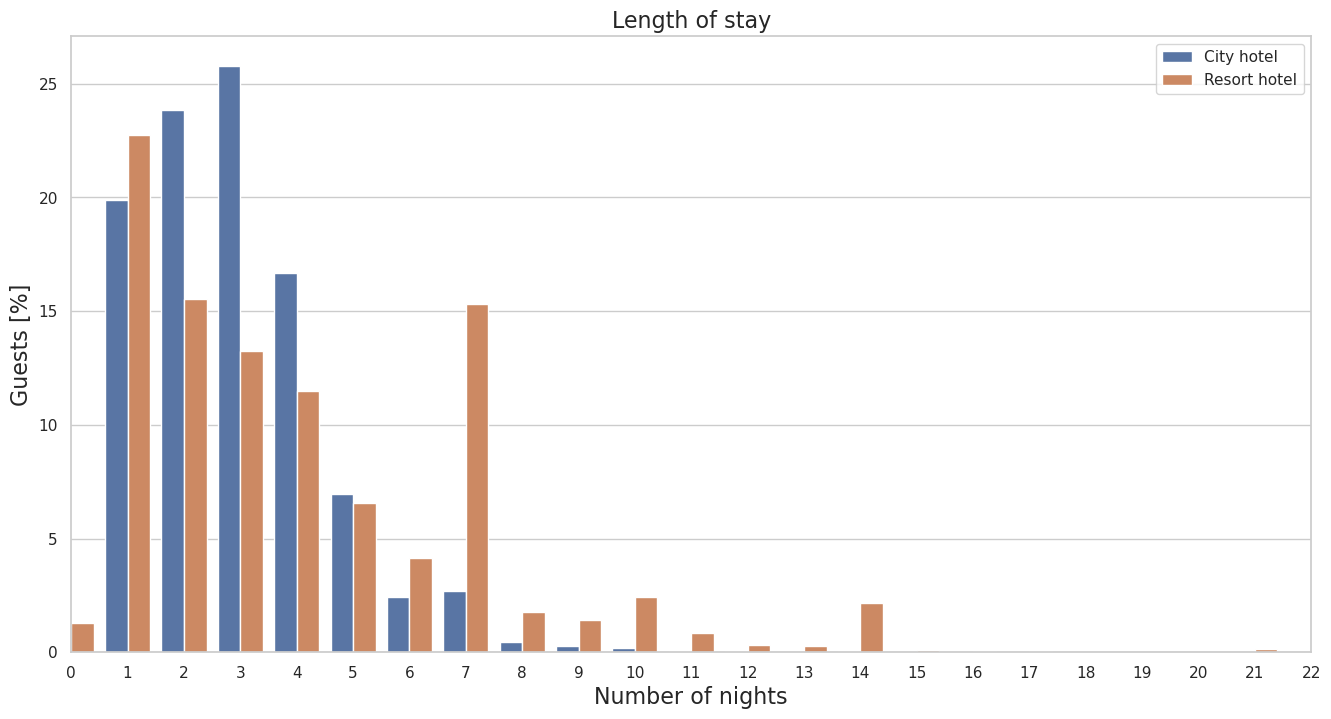

In [19]:
#show figure:
plt.figure(figsize=(16, 8))
sns.barplot(x = "num_nights", y = "rel_num_bookings", hue="hotel", data=nights_data,
            hue_order = ["City hotel", "Resort hotel"])
plt.title("Length of stay", fontsize=16)
plt.xlabel("Number of nights", fontsize=16)
plt.ylabel("Guests [%]", fontsize=16)
plt.legend(loc="upper right")
plt.xlim(0,22)
plt.show()


In [20]:
avg_nights_res = sum(list((res_nights["num_nights"] * (res_nights["rel_num_bookings"]/100)).values))
avg_nights_cty = sum(list((cty_nights["num_nights"] * (cty_nights["rel_num_bookings"]/100)).values))
print(f"On average, guests of the City hotel stay {avg_nights_cty:.2f} nights, and {cty_nights['num_nights'].max()} at maximum.")
print(f"On average, guests of the Resort hotel stay {avg_nights_res:.2f} nights, and {res_nights['num_nights'].max()} at maximum.")

On average, guests of the City hotel stay 2.92 nights, and 48 at maximum.
On average, guests of the Resort hotel stay 4.14 nights, and 69 at maximum.


The city hotel demonstrates a distinct preference for bookings spanning 1 to 4 nights. Similarly, the resort hotel frequently sees bookings for 1 to 4 nights; however, a notable trend is the popularity of 7-night stays.

# Bookings by market segment

In [21]:
# total bookings per market segment (incl. canceled)
segments=full_data_cln["market_segment"].value_counts()

# pie plot
fig = px.pie(segments,
             values=segments.values,
             names=segments.index,
             title="Bookings per market segment",
             template="seaborn")
fig.update_traces(rotation=-90, textinfo="percent+label")
fig.show()


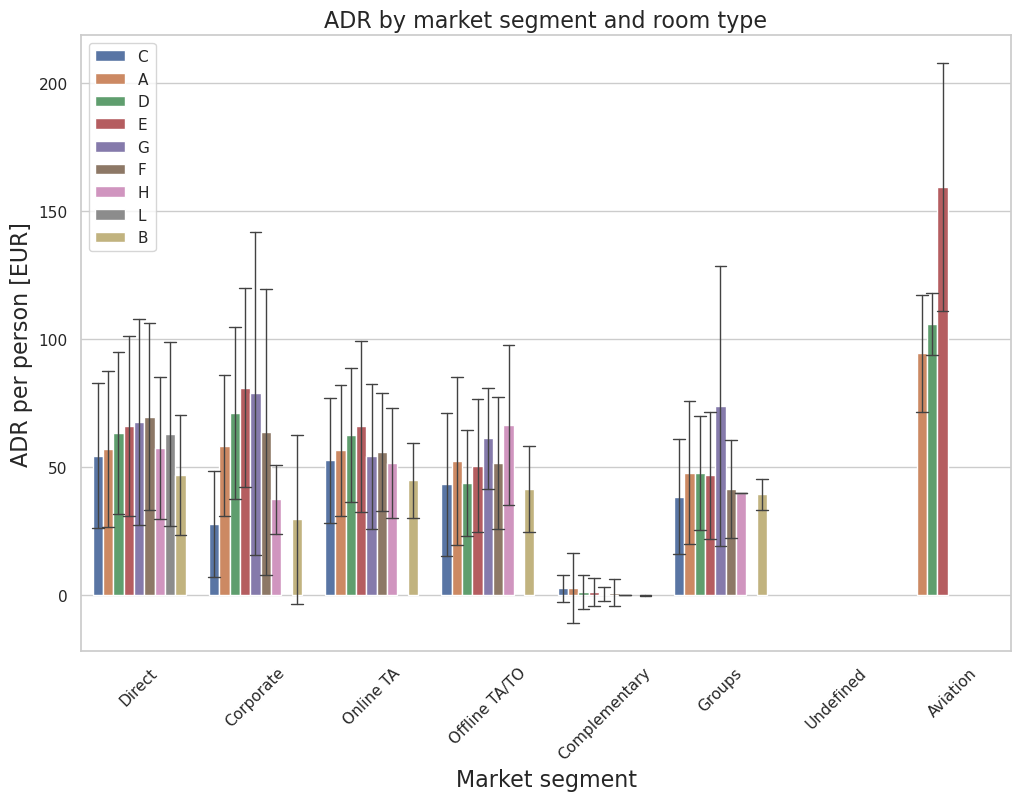

In [22]:
# price per night (ADR) and person based on booking and room.
# show figure:
plt.figure(figsize=(12, 8))
sns.barplot(x="market_segment",
            y="adr_pp",
            hue="reserved_room_type",
            data=full_data_cln,
            ci="sd",
            errwidth=1,
            capsize=0.1)
plt.title("ADR by market segment and room type", fontsize=16)
plt.xlabel("Market segment", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("ADR per person [EUR]", fontsize=16)
plt.legend(loc="upper left")
plt.show()


Groups tend to receive the most favorable prices on average, while airlines tend to pay approximately double the amount. What could be the potential reasons behind the higher prices paid by airlines?

In [23]:
# Summarize Relevant data:
Airline_data = full_data_cln.loc[full_data_cln["market_segment"]== "Aviation"][["is_canceled",
                                                                                "adults",
                                                                                "lead_time",
                                                                                "adr_pp",]].describe()

Non_Airline_data = full_data_cln.loc[full_data_cln["market_segment"]!= "Aviation"][["is_canceled",
                                                                                    "adults",
                                                                                    "lead_time",
                                                                                    "adr_pp",]].describe()

In [26]:
Airline_data

,is_canceled,adults,lead_time,adr_pp
count,235.000000,235.000000,235.00000,235.000000
mean,0.221277,1.012766,4.47234,100.270979
std,0.415992,0.112503,4.61629,20.376689
min,0.000000,1.000000,0.00000,0.000000
25%,0.000000,1.000000,1.00000,95.000000
50%,0.000000,1.000000,3.00000,95.000000
75%,0.000000,1.000000,6.00000,110.000000
max,1.000000,2.000000,23.00000,193.500000


In [27]:
Non_Airline_data

,is_canceled,adults,lead_time,adr_pp
count,118975.000000,118975.000000,118975.000000,118971.000000
mean,0.371061,1.860878,104.306031,55.038212
std,0.483091,0.574499,106.888885,29.016998
min,0.000000,0.000000,0.000000,-3.190000
25%,0.000000,2.000000,18.000000,37.440000
50%,0.000000,2.000000,69.000000,49.500000
75%,1.000000,2.000000,161.000000,66.000000
max,1.000000,55.000000,737.000000,2700.000000


- Bookings from the aviation sector typically have a significantly shorter lead time, with an average of 4 days compared to 104 days for other types of bookings.
- Airlines have a critical need for accommodations to house their crews during layovers or other operational requirements.
- In general, airline personnel typically require one room per person, resulting in a higher total room count compared to bookings made by families or other groups.

# How many bookings were canceled?

In [28]:
# absolute cancelations:
total_cancelations = full_data_cln["is_canceled"].sum()
rh_cancelations = full_data_cln.loc[full_data_cln["hotel"] == "Resort Hotel"]["is_canceled"].sum()
ch_cancelations = full_data_cln.loc[full_data_cln["hotel"] == "City Hotel"]["is_canceled"].sum()

# as percent:
rel_cancel = total_cancelations / full_data_cln.shape[0] * 100
rh_rel_cancel = rh_cancelations / full_data_cln.loc[full_data_cln["hotel"] == "Resort Hotel"].shape[0] * 100
ch_rel_cancel = ch_cancelations / full_data_cln.loc[full_data_cln["hotel"] == "City Hotel"].shape[0] * 100

print(f"Total bookings canceled: {total_cancelations:,} ({rel_cancel:.0f} %)")
print(f"Resort hotel bookings canceled: {rh_cancelations:,} ({rh_rel_cancel:.0f} %)")
print(f"City hotel bookings canceled: {ch_cancelations:,} ({ch_rel_cancel:.0f} %)")

Total bookings canceled: 44,199 (37 %)
Resort hotel bookings canceled: 11,120 (28 %)
City hotel bookings canceled: 33,079 (42 %)


# Which month have the highest number of cancelations?

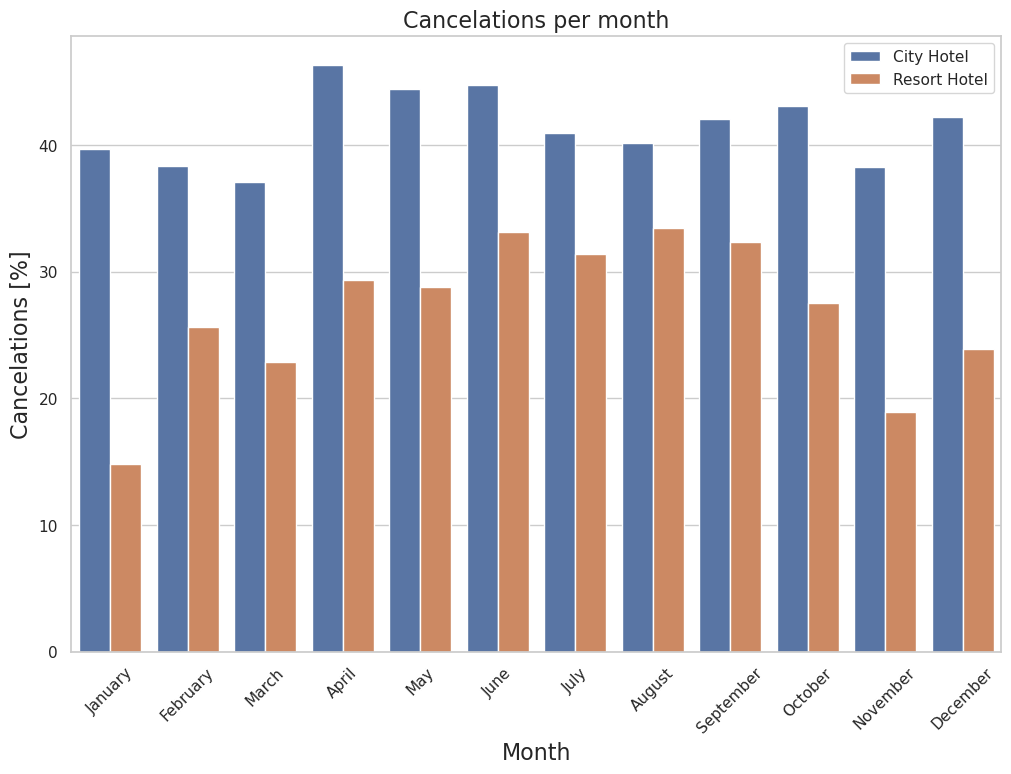

In [29]:
# Create a DateFrame with the relevant data:
res_book_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["hotel"].count()
res_cancel_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

cty_book_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel")].groupby("arrival_date_month")["hotel"].count()
cty_cancel_per_month = full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

res_cancel_data = pd.DataFrame({"Hotel": "Resort Hotel",
                                "Month": list(res_book_per_month.index),
                                "Bookings": list(res_book_per_month.values),
                                "Cancelations": list(res_cancel_per_month.values)})
cty_cancel_data = pd.DataFrame({"Hotel": "City Hotel",
                                "Month": list(cty_book_per_month.index),
                                "Bookings": list(cty_book_per_month.values),
                                "Cancelations": list(cty_cancel_per_month.values)})

full_cancel_data = pd.concat([res_cancel_data, cty_cancel_data], ignore_index=True)
full_cancel_data["cancel_percent"] = full_cancel_data["Cancelations"] / full_cancel_data["Bookings"] * 100

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
full_cancel_data["Month"] = pd.Categorical(full_cancel_data["Month"], categories=ordered_months, ordered=True)

# show figure:
plt.figure(figsize=(12, 8))
sns.barplot(x = "Month", y = "cancel_percent" , hue="Hotel",
            hue_order = ["City Hotel", "Resort Hotel"], data=full_cancel_data)
plt.title("Cancelations per month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.legend(loc="upper right")
plt.show()



- The City hotel experiences an average cancellation rate of approximately 40% consistently throughout the year.
- On the other hand, the Resort hotel observes its highest cancellation rate during the summer season, while the rate is lowest during the winter months.

# 2. Predict cancelations

## Which numerical features hold the highest level of importance?

In [31]:
cancel_corr = data.corr()["is_canceled"]
cancel_corr.abs().sort_values(ascending=False)[1:]

lead_time                         0.293123
total_of_special_requests         0.234658
required_car_parking_spaces       0.195498
booking_changes                   0.144381
previous_cancellations            0.110133
is_repeated_guest                 0.084793
agent                             0.083114
adults                            0.060017
previous_bookings_not_canceled    0.057358
days_in_waiting_list              0.054186
adr                               0.047557
babies                            0.032491
stays_in_week_nights              0.024765
company                           0.020642
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
arrival_date_day_of_month         0.006130
children                          0.005048
stays_in_weekend_nights           0.001791
Name: is_canceled, dtype: float64

Based on the provided list, it is evident that lead_time, total_of_special_requests, required_car_parking_spaces, booking_changes, and previous_cancellations are the top five significant numerical features. However, when predicting booking cancellations, the number of booking changes poses a potential source of data leakage since this information can change over time. Additionally, the features days_in_waiting_list and arrival_date_year will not be considered.

It is crucial to note that the most important feature to exclude from the analysis is "reservation_status".

In [33]:
data.groupby("is_canceled")["reservation_status"].value_counts()

is_canceled  reservation_status
0            Check-Out             75166
1            Canceled              43017
             No-Show                1207
Name: reservation_status, dtype: int64

## Comparing different base models:

In [35]:
# manually choose columns to include
# some columns are excluded to make the model more general and to prevent leakage
# (arrival_date_year, assigned_room_type, booking_changes, reservation_status, country,
# days_in_waiting_list)
# including the country would increase accuracy, but it may also make the model less general

num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent","company",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]

# Separate features and predicted value
features = num_features + cat_features
X = data.drop(["is_canceled"], axis=1)[features]
y = data["is_canceled"]

# preprocess numerical feats:
# for most num cols, except the dates, 0 is the most logical choice as fill value
# and here no dates are missing.
num_transformer = SimpleImputer(strategy="constant")

# Preprocessing for categorical features:
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical features:
preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])

In [36]:
# define models to test:
base_models = [("DT_model", DecisionTreeClassifier(random_state=42)),
               ("RF_model", RandomForestClassifier(random_state=42,n_jobs=-1)),
               ("LR_model", LogisticRegression(random_state=42,n_jobs=-1)),
               ("XGB_model", XGBClassifier(random_state=42, n_jobs=-1))]

# split data into 'kfolds' parts for cross validation,
# use shuffle to ensure random distribution of data:
kfolds = 4 # 4 = 75% train, 25% validation
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

# Preprocessing, fitting, making predictions and scoring for every model:
for name, model in base_models:
    # pack preprocessing of data and the model in a pipeline:
    model_steps = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])
    
    # get cross validation score for each model:
    cv_results = cross_val_score(model_steps, 
                                 X, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
    # output:
    min_score = round(min(cv_results), 4)
    max_score = round(max(cv_results), 4)
    mean_score = round(np.mean(cv_results), 4)
    std_dev = round(np.std(cv_results), 4)
    print(f"{name} cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")
    
    #pipeline.fit(X_train, y_train)
    #preds = pipeline.predict(X_valid)
    #score = accuracy_score(y_valid, preds)
    #print(f"{name} accuracy_score: {round(score, 4)}")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


DT_model cross validation accuarcy score: 0.8246 +/- 0.0016 (std) min: 0.8221, max: 0.8263
RF_model cross validation accuarcy score: 0.8664 +/- 0.0012 (std) min: 0.8646, max: 0.8676


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LR_model cross validation accuarcy score: 0.7937 +/- 0.0011 (std) min: 0.7921, max: 0.7951
XGB_model cross validation accuarcy score: 0.8473 +/- 0.0011 (std) min: 0.8456, max: 0.8487


**The RandomForst model performs best.**

In [37]:
# Enhanced RF model with the best parameters I found:
rf_model_enh = RandomForestClassifier(n_estimators=160,
                               max_features=0.4,
                               min_samples_split=2,
                               n_jobs=-1,
                               random_state=0)

split = KFold(n_splits=kfolds, shuffle=True, random_state=42)
model_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', rf_model_enh)])
cv_results = cross_val_score(model_pipe, 
                                 X, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
# output:
min_score = round(min(cv_results), 4)
max_score = round(max(cv_results), 4)
mean_score = round(np.mean(cv_results), 4)
std_dev = round(np.std(cv_results), 4)
print(f"Enhanced RF model cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")

Enhanced RF model cross validation accuarcy score: 0.8681 +/- 0.0006 (std) min: 0.8673, max: 0.869


## 3. Evaluate Feature importance

In [42]:
# fit model(pipeline) so values can be accessed:
model_pipe.fit(X,y)

# Names of all (encoded) features are needed.
# Get names of columns from One Hot Encoding:
onehot_columns = list(model_pipe.named_steps['preprocessor'].
                      named_transformers_['cat'].
                      named_steps['onehot'].
                      get_feature_names_out(input_features=cat_features))

# Add num_features for full list.
# Order must be as in definition of X, where num_features are first: 
feat_imp_list = num_features + onehot_columns

# show 10 most important features, provide names of features:
feat_imp_df = eli5.formatters.as_dataframe.explain_weights_df(
    model_pipe.named_steps['model'],
    feature_names=feat_imp_list)
feat_imp_df.head(10)

,feature,weight,std
0,lead_time,0.145140,0.015235
1,deposit_type_Non Refund,0.140641,0.108007
2,adr,0.096222,0.003412
3,deposit_type_No Deposit,0.079059,0.106235
4,arrival_date_day_of_month,0.069410,0.002033
5,arrival_date_week_number,0.053763,0.001999
6,total_of_special_requests,0.050567,0.013314
7,agent,0.043060,0.006392
8,stays_in_week_nights,0.041588,0.002291
9,previous_cancellations,0.038626,0.013459


**Looking at the three most important features:**
* lead_time
* deposit_type
* adr

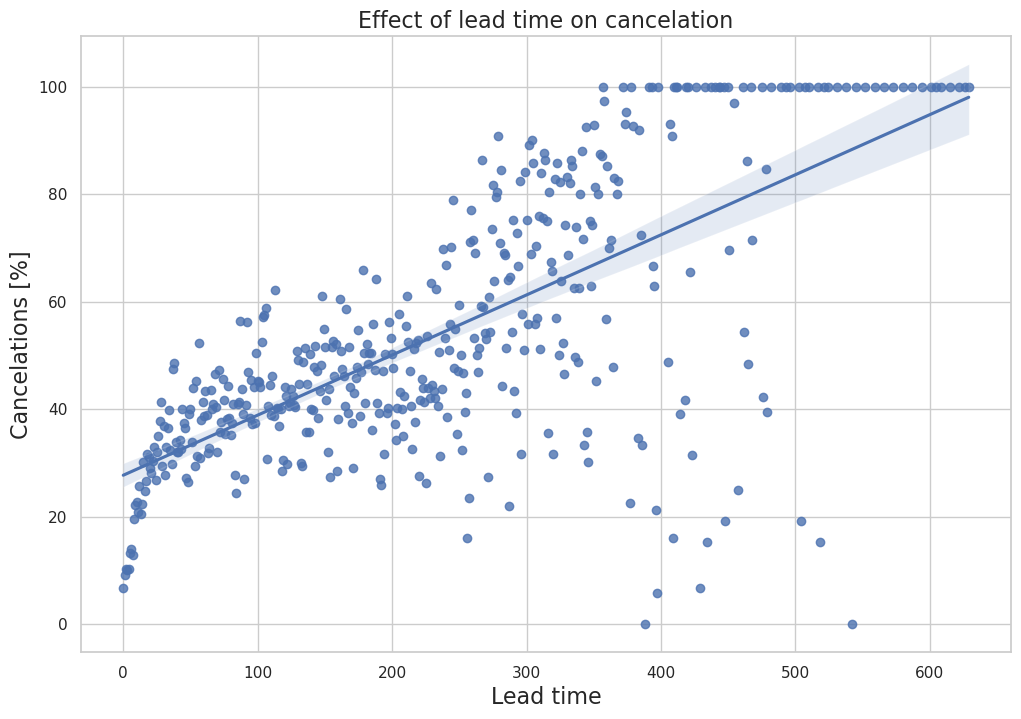

In [43]:
# group data for lead_time:
lead_cancel_data = full_data_cln.groupby("lead_time")["is_canceled"].describe()
# use only lead_times wih more than 10 bookings for graph:
lead_cancel_data_10 = lead_cancel_data.loc[lead_cancel_data["count"] >= 10]

#show figure:
plt.figure(figsize=(12, 8))
sns.regplot(x=lead_cancel_data_10.index, y=lead_cancel_data_10["mean"].values * 100)
plt.title("Effect of lead time on cancelation", fontsize=16)
plt.xlabel("Lead time", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
# plt.xlim(0,365)
plt.show()

**Bookings made a few days before the arrival date are rarely canceled, whereas bookings made over one year in advance are canceled very often.**

## Deposit type:

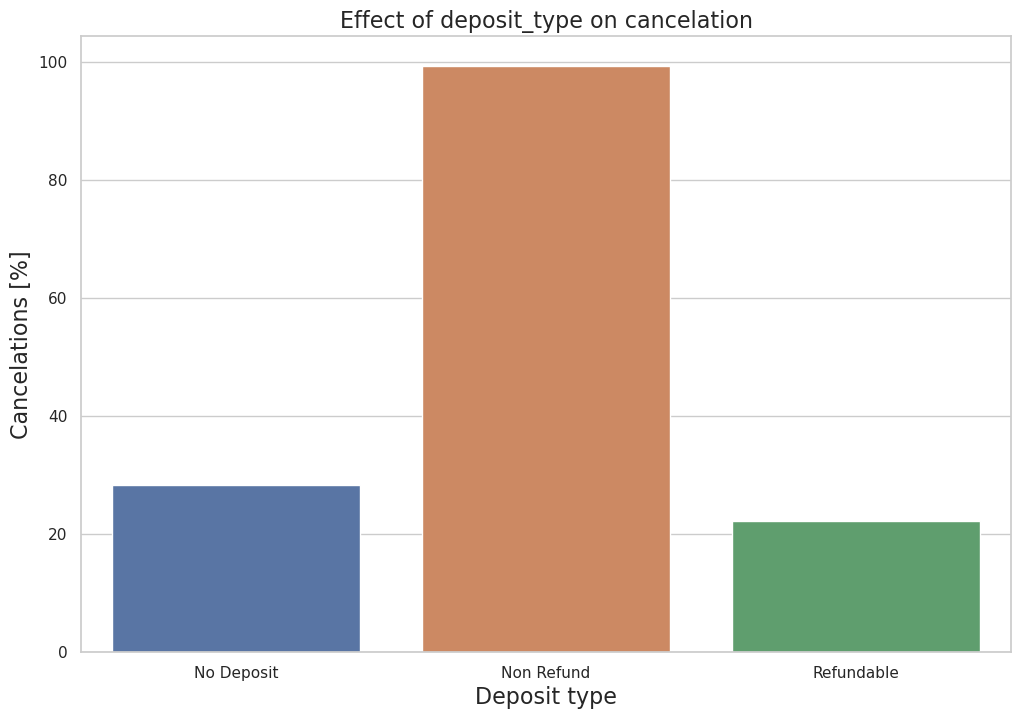

In [44]:
# group data for deposit_type:
deposit_cancel_data = full_data_cln.groupby("deposit_type")["is_canceled"].describe()

#show figure:
plt.figure(figsize=(12, 8))
sns.barplot(x=deposit_cancel_data.index, y=deposit_cancel_data["mean"] * 100)
plt.title("Effect of deposit_type on cancelation", fontsize=16)
plt.xlabel("Deposit type", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.show()


As highlighted by Susmit Vengurlekar in the Discussion section of the dataset, there exists a counter-intuitive correlation between the deposit_type 'Non Refund' and the 'is_canceled' column.

It is noteworthy that over 99% of individuals who paid the full amount upfront eventually canceled their bookings. This raises concerns regarding the accuracy or description of the data.

Apart from the aforementioned observation, what other notable patterns or insights can be observed for Non Refund deposits?

Below is a table presenting the mean values of the dataset, grouped by deposit type:

In [45]:

deposit_mean_data = full_data_cln.groupby("deposit_type").mean()
deposit_mean_data

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,adr_pp
deposit_type,,,,,,,,,,,,,,,,,,,,,
No Deposit,0.284020,88.841951,2016.173950,27.133208,15.815223,0.969615,2.555633,1.865806,0.118604,0.009085,0.035295,0.042044,0.154938,0.247030,78.745503,11.175874,1.518040,103.685436,0.071184,0.651726,55.233383
Non Refund,0.993624,212.908891,2016.031466,27.448619,15.595462,0.621718,2.091109,1.811407,0.000617,0.000000,0.004387,0.411462,0.010626,0.012477,47.480016,6.215809,7.992253,89.964017,0.000069,0.001782,54.520286
Refundable,0.222222,152.098765,2016.141975,20.932099,23.456790,0.975309,2.851852,1.907407,0.030864,0.000000,0.024691,0.000000,0.018519,0.592593,56.185185,133.666667,9.586420,76.209753,0.123457,0.141975,41.444239


Upon comparing the mean values for Non Refund deposits to No Deposit, the following observations emerge:

- Non Refund deposits are associated with lead times that are more than twice as long.
- The occurrence of being a repeated guest is approximately one-tenth for Non Refund deposits.
- The count of previous cancellations is ten times higher for Non Refund deposits.
- Non Refund deposits exhibit approximately 15 times fewer previous bookings that were not canceled.
- The requirement for car parking spaces is nearly non-existent for Non Refund deposits.
- Special requests are notably rare for Non Refund deposits.

Based on these findings, it appears that individuals who have not previously visited either of the hotels tend to book, pay, and cancel repeatedly—a peculiar trend.

To address this unusual pattern, I will create a model that excludes this feature. Please find the model without this feature provided below.

## ADR: 

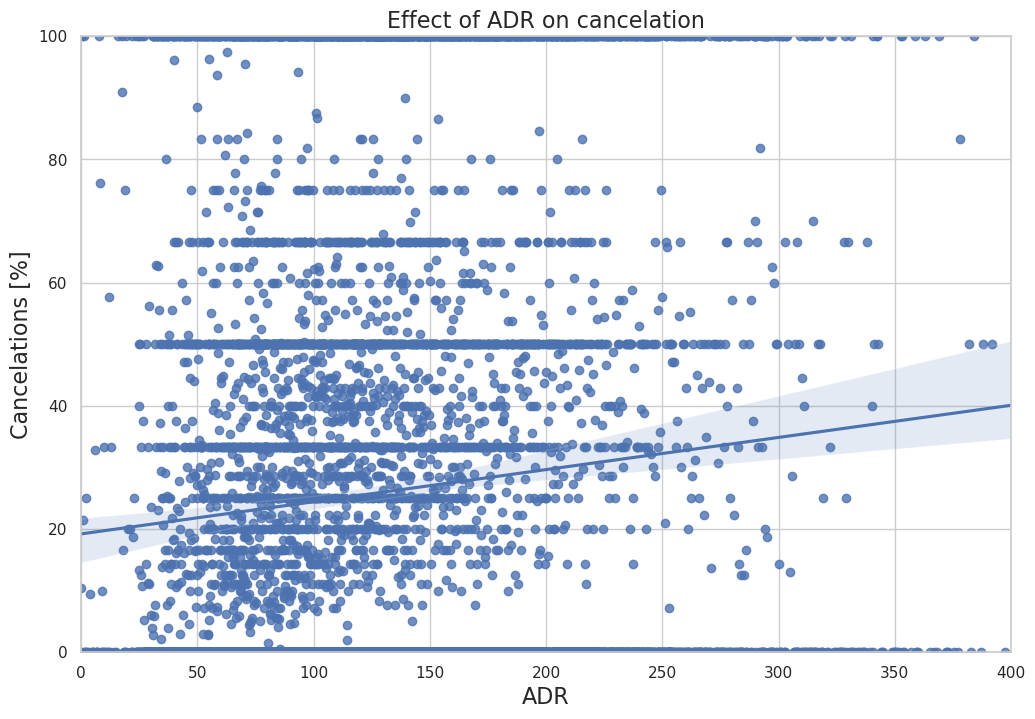

In [46]:
# group data for adr:
adr_cancel_data = full_data_cln.groupby("adr")["is_canceled"].describe()
#show figure:
plt.figure(figsize=(12, 8))
sns.regplot(x=adr_cancel_data.index, y=adr_cancel_data["mean"].values * 100)
plt.title("Effect of ADR on cancelation", fontsize=16)
plt.xlabel("ADR", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.xlim(0,400)
plt.ylim(0,100)
plt.show()


## RF model without deposit type:

In [49]:
cat_features_non_dep = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","customer_type"]

features_non_dep = num_features + cat_features_non_dep
X_non_dep = data.drop(["is_canceled"], axis=1)[features_non_dep]


# Bundle preprocessing for numerical and categorical features:
preprocessor_non_dep = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features_non_dep)])

# Define dataset:
X_non_dep = data.drop(["is_canceled"], axis=1)[features_non_dep]
# Define model
rf_model_non_dep = RandomForestClassifier(random_state=42) # basic model for this purpose

kfolds=4
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)
model_pipe = Pipeline(steps=[('preprocessor', preprocessor_non_dep),
                              ('model', rf_model_non_dep)])
cv_results = cross_val_score(model_pipe, 
                                 X_non_dep, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
# output:
min_score = round(min(cv_results), 4)
max_score = round(max(cv_results), 4)
mean_score = round(np.mean(cv_results), 4)
std_dev = round(np.std(cv_results), 4)
print(f"RF model without deposit_type feature cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


RF model without deposit_type feature cross validation accuarcy score: 0.8653 +/- 0.0013 (std) min: 0.8631, max: 0.8663


In [50]:
# feat importance of original model:
feat_imp_df.head(10)

,feature,weight,std
0,lead_time,0.145140,0.015235
1,deposit_type_Non Refund,0.140641,0.108007
2,adr,0.096222,0.003412
3,deposit_type_No Deposit,0.079059,0.106235
4,arrival_date_day_of_month,0.069410,0.002033
5,arrival_date_week_number,0.053763,0.001999
6,total_of_special_requests,0.050567,0.013314
7,agent,0.043060,0.006392
8,stays_in_week_nights,0.041588,0.002291
9,previous_cancellations,0.038626,0.013459


In [52]:
# Check feature importance of new model:
# fit model(pipeline) so values can be accessed:
model_pipe.fit(X_non_dep,y)

# Names of all (encoded) features are needed.
# Get names of columns from One Hot Encoding:
onehot_columns = list(model_pipe.named_steps['preprocessor'].
                      named_transformers_['cat'].
                      named_steps['onehot'].
                      get_feature_names_out(input_features=cat_features_non_dep))

# Add num_features for full list.
# Order must be as in definition of X, where num_features are first: 
feat_imp_list = num_features + onehot_columns

# show 10 most important features, provide names of features:
feat_imp_df_non_dep = eli5.formatters.as_dataframe.explain_weights_df(
    model_pipe.named_steps['model'],
    feature_names=feat_imp_list)

In [53]:
# feat importance of new model:
feat_imp_df_non_dep.head(10)

,feature,weight,std
0,lead_time,0.175189,0.019580
1,adr,0.111566,0.008185
2,total_of_special_requests,0.078749,0.013435
3,arrival_date_day_of_month,0.076958,0.003056
4,arrival_date_week_number,0.060699,0.004069
5,agent,0.054862,0.009409
6,stays_in_week_nights,0.049275,0.004647
7,previous_cancellations,0.047592,0.016409
8,stays_in_weekend_nights,0.031298,0.002617
9,customer_type_Transient,0.028016,0.018087


The updated accuracy score of 0.8653 is remarkably similar to the score obtained when the deposit_type feature was included (0.8664), which indicates its significant impact on the model.

However, the new model has effectively compensated for the exclusion of the deposit_type feature by assigning increased weight to other relevant features, such as lead_time, adr, total_of_special_requests, and several others.